# CSC_52081_EP_TP1

File may be found in: [https://www.lix.polytechnique.fr/~jread](https://www.lix.polytechnique.fr/~jread/courses/inf581/labs/01/).

### Main Objectives 

Intelligent decision making involves several components. Today we study, in the context of a toy (low-dimensional, synthetic) example: *perception* (observation), *knowledge* (representation), *reasoning* (inference), and *acting* (decision-making). We will _not_ look at (today): learning and sequential decision making. Using probabalistic tools covered in the lecture (Bayesian networks, marginalization, ...), the objective is to design a rational/intelligent agent, i.e., an agent that maximizes its expected reward. 


### Instructions

Work your way through the notebook, and provide code where indicated to complete the tasks. Check Moodle for details on how to submit your work.

### Imports

First, we're going to import `numpy` and some utility functions/classes that we will use. make sure the `environment.py` is in your working directory. 

In [5]:
import numpy as np

In [6]:
import matplotlib.pyplot as plt

And we'll use the environment defined in the file `environment.py`

In [7]:
# if you are using Google Colab, uncomment the following line (then comment again when you have run it): 
# !wget https://www.lix.polytechnique.fr/~jread/courses/inf581/labs/01/environment.py
from environment import Environment


## The Environment and the Agent

Consider an intelligent agent as a robot tasked with catching rats in a storage room. It is night time, and the room is dark. You have to rely on auditory information only, but luckily the room is a mess with paper and other debris that means there are distinct sounds which are emitted by a rat as it touches different objects (namely, crinkling and rustling sounds). The room is rectangular, divided up into $n$ square tiles.  A rat has just entered the room (current time $t=1$). The agent waits $T$ seconds (i.e., until $t=T$), then makes a decision on if and where to pounce (in order to catch the rat).

Let's instantiate an environment, and render a visualisation of it. 

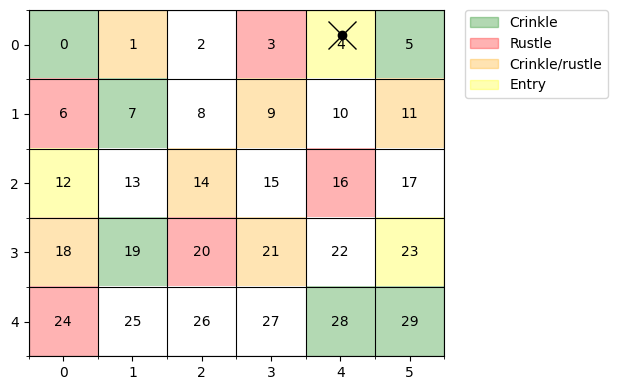

In [ ]:
G = np.array([[1,3,0,2,4,1],
              [2,1,0,3,0,3],
              [4,0,3,0,2,0],
              [3,1,2,3,0,4],
              [2,0,0,0,1,1]])

env = Environment(G)
# Plot the environment in state 's_t = 4'
fig, ax = env.render([4], None)
plt.show()

*trofino:* here environment is defined by a matrix representing what each cell contains:
- 0: no information
- 1: crinkle (type of sound)
- 2: rustle (type of sound)
- 3: crinkle and rustle
- 4: possible start position

'x' represents the end position of the agent.

#### Notation

Let $s_t \in \{1,\ldots,n\}$ denote the position (state) of the rat at time step $t$ (one of $n$ grid tiles); starting at some $s_1$ (entry tile). And $\mathbf{x}_t \in \{0,1\}^2$ is the 2-dimensional auditory observation at time $t$ (e.g., $\mathbf{x}_t = [1,0]$ if there is a crinkle but no rustle, etc). The agent accumulates a sequence of **observations** $\mathbf{x}_{1:T} = \mathbf{x}_1,\ldots,\mathbf{x}_T$, with which to make the decision of taking **action** $a$ to pounce (denoting the tile upon which it pounces). The agent obtains **reward** $r(s,a) = 1_{s = a}$, i.e., catching the rat provides reward $1$ and $0$ otherwise. 

As an influence diagram, the problem described can be depicted as follows: 

![pgm](https://www.lix.polytechnique.fr/~jread/courses/inf581/labs/01/fig/pgm.png)

Your task is to model this problem in Python code. Finally, the goal is to implement an `Agent` which will provide the best action $a$ (according to current knowledge, i.e., given observation sequence $\mathbf{x}_{1:T}$) and associated uncertainty.

**Beware** of the potential confusion here: $s_T$ represents the state of the environment but decision making (choosing action $a$) is based on observation $o = \mathbf{x}_{1:T}$. 

The Environment is fully specified for you, as a Markov process 
$$
    s_{t+1} \sim p(\cdot | s_t)
$$
with observations 
$$
    \mathbf{x}_t \sim p( \cdot | s_t)
$$
You can find this functionality in the `step` function. 

You should be able to see by looking at the code, that the rat moves by exactly $1$ square tile, either horizontally or vertically (i.e., taxicab-distance) per time step $t$, within the bounds of the of the room, starting at one of the entry points (uniformly at random). Insofar as the observation function: a 'crinkle' indicator is generated with probability $\theta_1$ when over certain tiles (green, or orange), and with probability $0$ over other tiles; furthermore, it will invoke a 'rustling' is indicated with probability $\theta_2$ over certain tiles (red, or orange), and $0$ otherwise. On orange tiles, both noises are caused independently of each other.


#### Task 1: Generating trajectories 

Complete the `gen_traj` function to generate a trajectory (of length $T$). You have full acces to the environment, e.g., you can call `env.step(...)`. 

In [65]:
def gen_traj(env, T=5):
    ''' Generate a path with associated observations.


        Paramaters
        ----------

        T : int
            how long is the path

        Returns
        -------

        o : (T,d)-shape array
            sequence of observations
        s : T-length array of states
            sequence of tiles
    '''
    s = np.zeros(T, dtype=int)
    o = np.zeros((T, 2), dtype=int)

    s[0] = np.random.choice(env.n_states,p=env.P_1)

    for t in range(1, T):
        s_t, o_t = env.step(s[t-1])

        s[t] = s_t
        o[t] = o_t

    return o, s

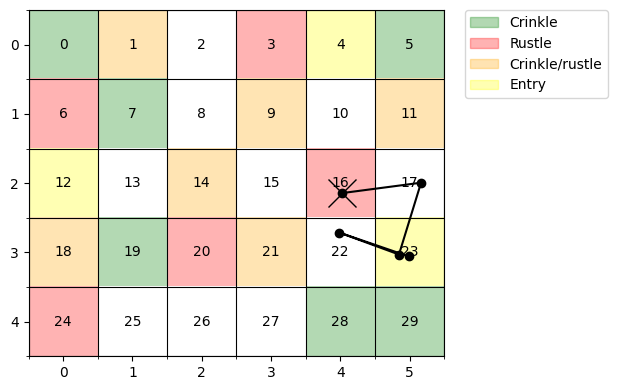

In [106]:
# Generate and view (plot) the trajectory
ooo, sss = gen_traj(env,5)
fig, ax = env.render(sss, ooo)
plt.show()

*trofino*: about circles:
- red circle: agent detected a rustle
- green circle: agent detected a crinkle

agent may have false positives when:
1. detecting sound where there isn't any
2. not detecting sound where there is.

It is important to realise that although we can have full access to the environment, as well as observations, we do not expect (in the 'real world') to see the true path $s_1,\ldots,s_T$ and hence the challenge in estimating $s_T$. For this we will create an `Agent` class.

In [107]:
class Agent: 

    def __init__(self, env): 
        '''
            env : Environment 
                of the type provided to you
        '''
        self.env = env

    # TODO (optional): Add any auxilliary functions you might use here 


    def P_traj(self, ooo, M=-1):
        '''
        Provides full conditional distribution P(SSS | ooo) where SSS and ooo are sequences of length T.
        $$
            P( Y_1,\ldots,Y_T | o_1,\ldots,o_T )
        $$


        Parameters
        ----------

        ooo : array_like(t, d)
            t observations (of d dimensions each)

        M : int
            -1 indicates to use a brute force solution (exact recovery of the distribution) 
            M > 0 indicates to use M Monte Carlo simulations (this parameter is used in Week 2)


        Returns
        -------

        p : dict(str:float)
            such that p[sss] = P(sss | ooo)
            and if sss not in p, it implies P(sss | ooo) = 0

            important: let sss be a string representation of the state sequence, separated by spaces, e.g., 
            the string representation of np.array([1,2,3,4],dtype=int) should be '1 2 3 4'. 
        ''' 
        p = {}

        

        # TODO 
        return p

        
    def P_S(self, o, t=-1): 
        '''
        Provide P(s_t | o) given observations o from 1,...,T.  

        $$
            P(S_t | o_1,...,o_T ).
        $$
        
        The probability (distribution) of the t-th state, given the observed evidence 'o'.

        Parameters
        ----------

        o : array_like(t,d)
            up to t observations (of d dimensions each)

        t : int
            the state being queried, e.g., 3, or -1 for final state (corresponding to o[-1])

        Returns
        -------

        P : array_like(float,ndim=1) 
            such that P[s] = P(S_t = s | o_1,...,o_t)
        '''
        # TODO 
        return P

    def Q(self, o): 
        '''
            Provide Q(o,a) for all a i.e., the value for any given a under observation o. 

            Parameters
            ----------

            o : array_like(int,ndim=2)
                t observations (of 2 bits each)

            Returns
            -------

            Q : array_like(float,ndim=n_actions)
                such that Q[a] is the value (expected reward) of action a.

        '''
        Q = np.zeros(env.n_states)
        # TODO 
        return Q

    def act(self, obs): 
        '''
        Decide on the best action to take, under the provided observation. 

        Parameters
        ----------

        obs : array_like(int,ndim=2)
            t observations (of 2 bits each)

        Returns
        -------

        a : int
            the chosen action a
        '''

        a = -1
        # TODO 
        return a

In [ ]:
# Let's instantiate our agent
agent = Agent(env)

The Agent is responsible for receiving observation $o = \mathbf{x}_{1:T}$ and producing prediction $a$, i.e., it implements $a = \pi(o)$, i.e., its policy or `act` function as it is called here below. But let's implement the functionality step by step. 

#### Task 2: Complete the `P_traj` function above, which specifies  
$$
    P(S_{1:T} | \mathbf{x}_{1:T})
$$
(returns a distribution, one number associated to each *possible* trajectory $s_1,\ldots,s_T$).


Implementation hint: For this, and remaining tasks. It may be useful to implement for the simple case of a single state observation (single time step) first. 

In [ ]:
# Call your function
P_joint = agent.P_traj(ooo)

# Check should sum to 1 (or close enough)
probs = list(P_joint.values())
assert abs(sum(probs) - 1) <= 0.05

# Extract possible paths
paths = [np.fromstring(k, sep=' ') for k in P_joint.keys()] 

# Take some samples
sample_indices = np.random.choice(len(probs), size=10, p=probs)
trajs = [paths[i].astype(int) for i in sample_indices]

# 